In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder


from sklearn.linear_model import LogisticRegression

In [2]:
test = pd.read_csv('/home/leandro/Documentos/Organizacion de datos/Fiuba-Big-Data-Analytics-TPs/Tp 2/Datos/Test_TP2_Datos_2020-2C.csv')

train = pd.read_csv('/home/leandro/Documentos/Organizacion de datos/Fiuba-Big-Data-Analytics-TPs/Tp 2/Datos/Train_TP2_Datos_2020-2C.csv')

In [3]:

def normaliza_df(df, ones_hots):
    # inicialmente voy con el tratamiento mas simple sobre los datos faltantes
    df = df.fillna(0)
    df = df.dropna()
    '''
      removemos la columna de la cual el modelo podria aprender que su existencia
      implica el Closed_won (ya que es un valor que se obtiene a posteriori de haber
      ganado y estaria mal usarlo ya que los modelos entrenadas con ella serian 
      incapaces de poder predecir correctamente)
    '''
    df = df.drop(['Sales_Contract_No'], axis=1)
    
    # irrelevantes
    df = df.drop(['Opportunity_Name'], axis=1)

    # dato cte = NaT
    df = df.drop(['Last_Activity'], axis=1)

    # basado en lo charlado con el grupo, ahora subdividimos el df de forma de tener
    # en cuenta los casos cerrados y cobertimos las varaibles categorias en su
    # representacion mas simple (siendo dos casos en Cloased_Won = 1 y Closed:_lost = 0)
    if 'Stage' in df.columns:
        df = df[((df['Stage'] == 'Closed Won') | (df['Stage'] == 'Closed Lost'))]
        df['Stage'] = df['Stage'].apply(lambda x: 1 if x == 'Closed Won' else 0)
    
    # hacemos que las variables temporales en las que nos vanos a enfocar sean del tipo correcto
    df['Account_Created_Date'] = pd.to_datetime(df['Account_Created_Date'], format="%m/%d/%Y")
    df['Opportunity_Created_Date'] = pd.to_datetime(df['Opportunity_Created_Date'], format="%m/%d/%Y")

    df['Quote_Type'] = df['Quote_Type'].apply(lambda x: 1 if x == 'Binding' else 0)
    
    # todo: convertir estas en una ventana de tiempo
    df = df.drop(['Planned_Delivery_Start_Date'], axis=1)
    df = df.drop(['Planned_Delivery_End_Date'], axis=1)

    categoric_cols = df.columns[df.dtypes==object].tolist() 
    numeric_cols = df.columns[df.dtypes=='float64'].tolist() 
    numeric_cols_2 = df.columns[df.dtypes=='int64'].tolist() 
    date_cols = df.columns[df.dtypes=='datetime64[ns]'].tolist() 
    
    print(categoric_cols)
    print('--------------')
    
    
    def crearOneHotDF(c1):
        if 'Stage' in df.columns:
            onehotencoder = OneHotEncoder(handle_unknown = 'ignore')
            onehotencoder.fit(df[[c1]])
            ones_hots[c1] = onehotencoder
        else:
            onehotencoder = ones_hots[c1]
        
        M = pd.DataFrame(onehotencoder.transform(df[[c1]]).toarray())
            
        num_cols = len(list(M))
        rng = range(0, num_cols)
        new_cols = [c1 + str(i) for i in rng] 
        M.columns = new_cols[:num_cols]
        return M

    categorical = pd.concat([crearOneHotDF(i) for i in categoric_cols], axis=1)

    df = pd.concat([categorical, df[numeric_cols], df[numeric_cols_2], df[date_cols]], axis=1)
    
    df = df.sort_values(by="Opportunity_Created_Date")
    
    df = df.drop(columns = 'Opportunity_Created_Date')
    df = df.drop(columns = 'Account_Created_Date')

    df = df.fillna(0)
    df = df.dropna()
    
    return df

# One hot

In [4]:
one_hots = {}
train_encodiado = normaliza_df(train,one_hots)
test_encodiado = normaliza_df(test,one_hots)

['Region', 'Territory', 'Bureaucratic_Code', 'Source ', 'Billing_Country', 'Account_Name', 'Account_Owner', 'Opportunity_Owner', 'Account_Type', 'Opportunity_Type', 'Delivery_Terms', 'Brand', 'Product_Type', 'Size', 'Product_Category_B', 'Price', 'Currency', 'Quote_Expiry_Date', 'Last_Modified_Date', 'Last_Modified_By', 'Product_Family', 'Product_Name', 'ASP_Currency', 'ASP_(converted)_Currency', 'Month', 'Delivery_Quarter', 'Actual_Delivery_Date', 'Total_Amount_Currency', 'Total_Taxable_Amount_Currency', 'Prod_Category_A']
--------------
['Region', 'Territory', 'Bureaucratic_Code', 'Source ', 'Billing_Country', 'Account_Name', 'Account_Owner', 'Opportunity_Owner', 'Account_Type', 'Opportunity_Type', 'Delivery_Terms', 'Brand', 'Product_Type', 'Size', 'Product_Category_B', 'Price', 'Currency', 'Quote_Expiry_Date', 'Last_Modified_Date', 'Last_Modified_By', 'Product_Family', 'Product_Name', 'ASP_Currency', 'ASP_(converted)_Currency', 'Month', 'Delivery_Quarter', 'Actual_Delivery_Date', 'T

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_encodiado.drop(columns = 'Stage'),train_encodiado['Stage'],test_size=0.3)

In [6]:
#Logistic Regression

lr = LogisticRegression(solver='liblinear',multi_class='ovr')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.591740412979351

In [7]:
predicts = lr.predict_proba(test_encodiado)
predicts

array([[0.426685  , 0.573315  ],
       [0.38717662, 0.61282338],
       [0.39041964, 0.60958036],
       ...,
       [0.40347374, 0.59652626],
       [0.40429736, 0.59570264],
       [0.43145608, 0.56854392]])

In [8]:
outputOneHot = pd.DataFrame({'Opportunity_ID':test_encodiado.Opportunity_ID, 'Target': predicts[:,1]})
outputOneHot = outputOneHot.groupby('Opportunity_ID').max()
outputOneHot

,Target
Opportunity_ID,
10689,0.555804
10690,0.554962
10691,0.577985
10692,0.608017
10693,0.562206
...,...
12364,0.600900
12365,0.596526
12366,0.595703


In [9]:
outputOneHot.to_csv('/home/leandro/Documentos/Organizacion de datos/Fiuba-Big-Data-Analytics-TPs/Tp 2/Resultados/LogisticRegressionScore1.csv')

# Funciones para variar parametros


In [10]:
def variar_penalty(X_train, y_train,X_test, y_test):
    scores = []
    for i in [ "l2", "none"]:

        lr = LogisticRegression(penalty =i)
        lr.fit(X_train, y_train)
        scores.append(lr.score(X_test, y_test))
    
    return scores

In [11]:
def variar_C(X_train, y_train,X_test, y_test):
    scores = []
    for i in np.linspace(0.01,1,50):

        lr = LogisticRegression(C=i)
        lr.fit(X_train, y_train)
        scores.append(lr.score(X_test, y_test))
    
    return scores

In [12]:
def variar_solver(X_train, y_train,X_test, y_test):
    scores = []
    
    for i in ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]:

        lr = LogisticRegression(solver = i)
        lr.fit(X_train, y_train)
        scores.append(lr.score(X_test, y_test))
    
    return scores

# Pruebo variendo los hiper parametros con OneHot


In [13]:
#Variar el penalty tampoco influye
scores=variar_penalty(X_train, y_train,X_test, y_test)

scores   

[0.5903638151425762, 0.5903638151425762]

In [14]:
#Variar c no mejora nada
scores2=variar_C(X_train, y_train,X_test, y_test)
scores2

[0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151425762,
 0.5903638151

In [15]:
scores3=variar_solver(X_train, y_train,X_test, y_test)
scores3

/home/leandro/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/leandro/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning

[0.7634218289085546,
 0.5903638151425762,
 0.591740412979351,
 0.43146509341199607,
 0.4277286135693215]

In [16]:
d = {'score': scores3, 'name': ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}
df =pd.DataFrame(data = d)
df

,score,name
0,0.763422,newton-cg
1,0.590364,lbfgs
2,0.591740,liblinear
3,0.431465,sag
4,0.427729,saga


Text(0, 0.5, 'solver')

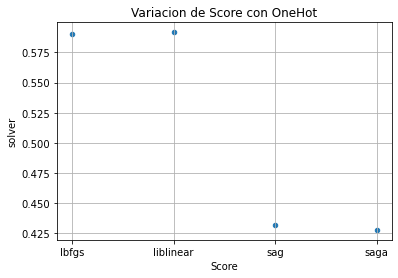

In [17]:
ax1 = df.drop([0],axis=0).plot.scatter(x='name',
                      y='score',grid=True, title = 'Variacion de Score con OneHot')

ax1.set_xlabel("Score")
ax1.set_ylabel("solver")


# Binary

In [18]:
train_binary =  pd.read_csv('/home/leandro/Documentos/Organizacion de datos/Fiuba-Big-Data-Analytics-TPs/Tp 2/Datos/TrainBinaryEncoding.csv')
test_binary =  pd.read_csv('/home/leandro/Documentos/Organizacion de datos/Fiuba-Big-Data-Analytics-TPs/Tp 2/Datos/TestBinaryEncoding.csv')

test_binary = test_binary.drop(columns ="Unnamed: 0")
train_binary = train_binary.drop(columns ="Unnamed: 0")



X_train, X_test, y_train, y_test = \
    train_test_split(train_binary.drop(columns = 'Stage'), train_binary['Stage'], test_size=0.2, random_state=123)


In [19]:

lr = LogisticRegression(solver='liblinear',multi_class='ovr')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.5960912052117264

In [20]:
predicts = lr.predict_proba(test_binary)
predicts

array([[0.49954235, 0.50045765],
       [0.49965422, 0.50034578],
       [0.49959009, 0.50040991],
       ...,
       [0.49980847, 0.50019153],
       [0.49972159, 0.50027841],
       [0.49825442, 0.50174558]])

In [21]:
outputBinary = pd.DataFrame({'Opportunity_ID':test_binary.Opportunity_ID, 'Target': predicts[:,1]})
outputBinary = outputBinary.groupby('Opportunity_ID').max()
outputBinary

,Target
Opportunity_ID,
10689,0.500458
10690,0.500831
10691,0.500034
10692,0.502073
10693,0.500003
...,...
12364,0.500257
12365,0.500081
12366,0.500192


In [22]:
outputBinary.to_csv('/home/leandro/Documentos/Organizacion de datos/Fiuba-Big-Data-Analytics-TPs/Tp 2/Resultados/LogisticRegressionScore2.csv')

# Vario parametro con el Binary

In [23]:
#Variar el penalty tampoco influye
scores=variar_penalty(X_train, y_train,X_test, y_test)
scores  

[0.5943144803079656, 0.5943144803079656]

In [24]:
#Variar c no mejora nada
scores2=variar_C(X_train, y_train,X_test, y_test)
scores2

[0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803079656,
 0.5943144803

In [25]:
scores3=variar_solver(X_train, y_train,X_test, y_test)
scores3

/home/leandro/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/leandro/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning

[0.8092981936630145,
 0.5943144803079656,
 0.5960912052117264,
 0.431448030796565,
 0.4284868226236304]

In [26]:
d = {'score': scores3, 'name': ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}
df =pd.DataFrame(data = d)
df

,score,name
0,0.809298,newton-cg
1,0.594314,lbfgs
2,0.596091,liblinear
3,0.431448,sag
4,0.428487,saga


Text(0, 0.5, 'solver')

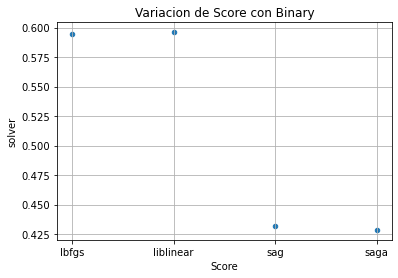

In [27]:
ax1 = df.drop([0],axis=0).plot.scatter(x='name',
                      y='score',grid=True, title = 'Variacion de Score con Binary')

ax1.set_xlabel("Score")
ax1.set_ylabel("solver")

# Archivos Fernando

In [28]:
test_fer = pd.read_csv('/home/leandro/Documentos/Organizacion de datos/Datos Pesados/210227_tp2_test_feng.csv')
train_fer = pd.read_csv('/home/leandro/Documentos/Organizacion de datos/Datos Pesados/210227_tp2_train_feng.csv')

In [29]:
X_train, X_test, y_train, y_test = \
    train_test_split(train_fer.drop(columns = 'Stage'), train_fer['Stage'], test_size=0.2, random_state=123)


In [30]:

lr = LogisticRegression(solver='liblinear',multi_class='ovr')
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.5666156202143952

In [31]:
predicts = lr.predict_proba(test_fer)
predicts

array([[0.4706627 , 0.5293373 ],
       [0.48115587, 0.51884413],
       [0.46300304, 0.53699696],
       ...,
       [0.45276036, 0.54723964],
       [0.45301865, 0.54698135],
       [0.45778136, 0.54221864]])

In [32]:
output = pd.DataFrame({'Opportunity_ID':test_fer.Opportunity_ID, 'Target': predicts[:,1]})
output = output.groupby('Opportunity_ID').max()
output

,Target
Opportunity_ID,
10689,0.529337
10690,0.518844
10691,0.536997
10692,0.483132
10693,0.537111
...,...
12364,0.545318
12365,0.547593
12366,0.547240


In [33]:
output.to_csv('/home/leandro/Documentos/Organizacion de datos/Fiuba-Big-Data-Analytics-TPs/Tp 2/Resultados/LogisticRegressionScore3.csv')

# Variando parametros con los datos de fernando

In [34]:
#Variar el penalty tampoco influye
scores=variar_penalty(X_train, y_train,X_test, y_test)
scores  




[0.5666156202143952, 0.5666156202143952]

In [35]:
#Variar c no mejora nada
scores2=variar_C(X_train, y_train,X_test, y_test)
scores2

[0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202143952,
 0.5666156202

In [36]:

scores3=variar_solver(X_train, y_train,X_test, y_test)
scores3

/home/leandro/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:477: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/leandro/anaconda3/lib/python3.8/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/utils/optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "
/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/leandro/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning

[0.7799897907095457,
 0.5666156202143952,
 0.5666156202143952,
 0.47371107708014293,
 0.47320061255742724]